We will be using the tweepy library to access Twitter's API and conduct some exploratory data analysis. First, we must authorize our new application to access Twitter.

In [1]:
import tweepy
from tweepy import OAuthHandler
import json

consumer_key = '___'
consumer_secret = '___'
access_token = '___'
access_secret = '___'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

We have now authorized our application to access Twitter. We can test this by printing out a tweet on our timeline. In this case, I am printing out my tweet: "demo tweet". As we can see, all components of this tweet are printed.

In [2]:
def process_tweets(tweet):
    print(json.dumps(tweet))

for tweet in tweepy.Cursor(api.user_timeline).items():
    process_tweets(tweet._json)

{"created_at": "Mon Jun 17 04:49:23 +0000 2019", "id": 1140481541539160065, "id_str": "1140481541539160065", "text": "demo tweet", "truncated": false, "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": []}, "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>", "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": {"id": 1138232906080370688, "id_str": "1138232906080370688", "name": "Robert", "screen_name": "Robert35487043", "location": "", "description": "", "url": null, "entities": {"description": {"urls": []}}, "protected": false, "followers_count": 0, "friends_count": 0, "listed_count": 0, "created_at": "Mon Jun 10 23:54:06 +0000 2019", "favourites_count": 0, "utc_offset": null, "time_zone": null, "geo_enabled": false, "verified": false, "statuses_count": 1, "lang": null, "contributors_enabled": false, "is_translator": 

Now, let's select some tweets using a specific hashtag. We will choose 100 tweets from 01/01/19 and beyond that contain the hashtag '#Democrat' and 50 tweets that contain the hashtag '#Republican'.

In [12]:
tweets_democrat = [tweet for tweet in tweepy.Cursor(api.search,
                                           q = "#Democrat",
                                           lang = "en",
                                           since = "2019-01-01").items(100)]

tweets_republican = [tweet for tweet in tweepy.Cursor(api.search,
                                           q = "#Republican",
                                           lang = "en",
                                           since = "2019-01-01").items(100)]

# for tweet_d in tweets_democrat:
#     print(tweet_d.text)
    
# for tweet_r in tweets_republican:
#     print(tweet_r.text)


We can tokenize the text in these tweets, but we must also consider irregular terms (emoticons, hashtags, number formatting, etc.). To account for this, we will use regex and a pre-processing function.

In [4]:
import re

emoticons_str = r"""(?:
    [:=;] #eyes
    [oO\-]? #nose
    [D\)\]\(\]/\\OpP] #mouth
    )"""

regex_str = [emoticons_str,
             r'<[^>]+>', #HTML
             r'(?:@[\w_]+)', #@-mentions
             r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", #hashtags
             r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', #URLs
             r'(?:(?:\d+,?)+(?:\.?\d+)?)', #numbers
             r"(?:[a-z][a-z'\-_]+[a-z])", #words containing - and '
             r'(?:[\w_]+)', #other words
             r'(?:\S)' #anything else
            ]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase = False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

# for tweet in tweets:
#     print(str(preprocess(tweet.text)) + '\n')

Now that we are able to tokenize each tweet, we can conduct some analysis on them. First, let's look at term frequency. We will be using NLTK library in order to remove common English stop-words, so we can focus solely on more useful terms.

In [5]:
from collections import Counter
from nltk.corpus import stopwords
import string

punctuation = list(string.punctuation)
terms_misc = ['rt', 'via', 'RT', '…', '’']
stop_lower = stopwords.words('english')
stop_upper = [word.upper() for word in stop_lower]
stop_proper = [word.capitalize() for word in stop_lower]
terms_useless = punctuation + terms_misc + stop_lower + stop_upper + stop_proper

count_all_democrat = Counter()
for tweet_d in tweets_democrat:
    terms_important_democrat = [term for term in preprocess(tweet_d.text) if term not in terms_useless
                                                                 and not term.startswith('@')
                                                                 and not term.startswith('#')
                                                                 and not term.startswith('https:')]
    count_all_democrat.update(terms_important_democrat)
    
count_all_republican = Counter()
for tweet_r in tweets_republican:
    terms_important_republican = [term for term in preprocess(tweet_r.text) if term not in terms_useless
                                                                 and not term.startswith('@')
                                                                 and not term.startswith('#')
                                                                 and not term.startswith('https:')]
    count_all_republican.update(terms_important_republican)

print(count_all_democrat.most_common(5))
print(count_all_republican.most_common(5))
# print(terms_useless)

[('racist', 33), ('wonder', 31), ('realize', 31), ('convince', 31), ('matter', 31)]
[('vote', 18), ('amp', 14), ('violence', 11), ('Please', 10), ('would', 9)]


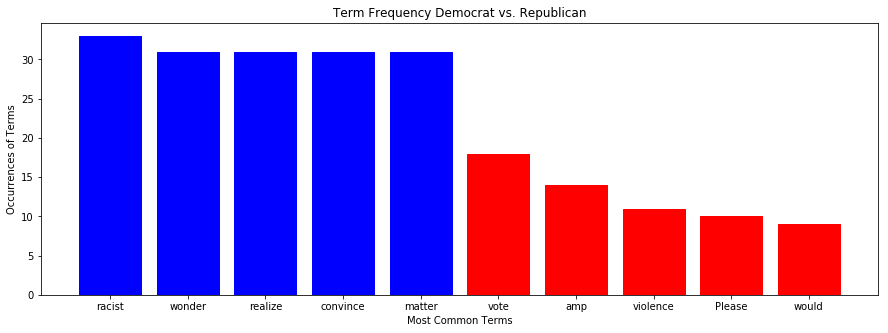

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

# amount of x-axis values
bottom = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# x-axis values for democrat and republican graphs respectively
x_d = [a[0] for a in count_all_democrat.most_common(5)]
x_r = [b[0] for b in count_all_republican.most_common(5)]
tick_label = x_d + x_r

# y-axis values for democrat and republican graphs respectively
y_d = [c[1] for c in count_all_democrat.most_common(5)]
y_r = [d[1] for d in count_all_republican.most_common(5)]
height = y_d + y_r


bar_graph = plt.bar(bottom, height, tick_label = tick_label, width = 0.8)
for i in [0,1,2,3,4]:
    bar_graph[i].set_color('blue')
    
for j in [5,6,7,8,9]:
    bar_graph[j].set_color('red') 

plt.xlabel('Most Common Terms') 
plt.ylabel('Occurrences of Terms')
plt.title('Term Frequency Democrat vs. Republican') 

plt.show() 

We can view sequences of 2 consecutive terms using bigrams from the NLTK libary.

In [11]:
from nltk import bigrams

terms_bigrams_democrat = bigrams(count_all_democrat)
count_all_bigram_democrat = Counter()

terms_bigrams_republican = bigrams(count_all_republican)
count_all_bigram_republican = Counter()

# print(list(terms_bigrams_democrat))
# print(list(terms_bigrams_republican))

The code above can be used to find term co-occurences.

In [10]:
from collections import defaultdict
import operator

com_democrat = defaultdict(lambda: defaultdict(int))
com_republican = defaultdict(lambda: defaultdict(int))

for tweet in tweets_democrat:
    terms_democrat = [term for term in preprocess(tweet.text) if term not in terms_useless
                                                                 and not term.startswith('@')
                                                                 and not term.startswith('#')
                                                                 and not term.startswith('https:')]
    # build co-occurrence matrix
    for i in range(len(terms_democrat) - 1):
        for j in range(i + 1, len(terms_democrat)):
            w1, w2 = sorted([terms_democrat[i], terms_democrat[j]])
            if w1 != w2:
                com_democrat[w1][w2] += 1
   
for tweet in tweets_republican:
    terms_republican = [term for term in preprocess(tweet.text) if term not in terms_useless
                                                                 and not term.startswith('@')
                                                                 and not term.startswith('#')
                                                                 and not term.startswith('https:')]
    for i in range(len(terms_republican) - 1):
        for j in range(i + 1, len(terms_republican)):
            w1, w2 = sorted([terms_republican[i], terms_republican[j]])
            if w1 != w2:
                com_republican[w1][w2] += 1

com_max_democrat = []
com_max_republican = []

# find most common co-occurence terms
for t1 in com_democrat:
    t1_max_terms_d = sorted(com_democrat[t1].items(), key = operator.itemgetter(1), reverse = True)[:5]
    for t2, t2_count in t1_max_terms_d:
        com_max_democrat.append(((t1, t2), t2_count))

for t1 in com_republican:
    t1_max_terms_r = sorted(com_republican[t1].items(), key = operator.itemgetter(1), reverse = True)[:5]
    for t2, t2_count in t1_max_terms_r:
        com_max_republican.append(((t1, t2), t2_count))
        
# get most frequent co-occurrences
terms_max_democrat = sorted(com_max_democrat, key = operator.itemgetter(1), reverse = True)
print(terms_max_democrat[:5])

terms_max_republican = sorted(com_max_republican, key = operator.itemgetter(1), reverse = True)
print(terms_max_republican[:5])

[(('destroy', 'vote'), 32), (('realize', 'wonder'), 31), (('realize', 'times'), 31), (('convince', 'wonder'), 31), (('convince', 'realize'), 31)]
[(('case', 'missed'), 9), (('case', 'foments'), 9), (('case', 'violence'), 9), (('case', 'murder'), 9), (('case', 'impunity'), 9)]
